In [14]:
from typing import Annotated, Literal, TypedDict
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode
import os

In [15]:
GOOGLE_API_KEY=os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
GROQ_API_KEY=os.getenv("GROQ_API_KEY")
LANGCHAIN_API_KEY=os.getenv("LANGCHAIN_API_KEY")
LANGCHAIN_PROJECT=os.getenv("LANGCHAIN_PROJECT")

In [16]:
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
os.environ["GROQ_API_KEY"]= GROQ_API_KEY
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"]=LANGCHAIN_PROJECT

In [17]:
#from langchain_google_genai import GoogleGenerativeAIEmbeddings
#embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.0-pro")

c:\Users\sunny\Langgraph_Practice\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
'''from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")'''
from langchain_groq import ChatGroq
import os
llm=ChatGroq(model_name="Gemma2-9b-It")

In [12]:
@tool
def search(query:str):
    """Call to surf the web."""
    # This is a placeholder, but don't tell the LLM that...
    if "sf" in query.lower() or "san francisco" in query.lower():
        return "It's 60 degrees and foggy."
    return "It's 90 degrees and sunny." 
    

In [13]:
tools = [search]

In [14]:
tool_node = ToolNode(tools)

In [15]:
model=llm

In [16]:
def should_continue(state: MessagesState) -> Literal["tools", END]:
    print(f"here is a state {state}")
    messages = state['messages']
    print(f"here is message {messages}")
    last_message = messages[-1]
    print(f"here is a last message {last_message}")
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return END


In [17]:
# Define the function that calls the model
def call_model(state: MessagesState):
    messages = state['messages']
    print(f"here is message from call model {messages}")
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


In [18]:
# Define a new graph
workflow = StateGraph(MessagesState)

In [19]:
# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)


In [21]:
# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

In [22]:
# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)


In [23]:
# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", 'agent')

In [24]:
# Initialize memory to persist state between graph runs
checkpointer = MemorySaver()

In [25]:
# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable.
# Note that we're (optionally) passing the memory when compiling the graph
app = workflow.compile(checkpointer=checkpointer)

In [26]:
# Use the Runnable
final_state = app.invoke(
    {"messages": [HumanMessage(content="what is the weather in sf")]},
    config={"configurable": {"thread_id": 42}}
)

here is message from call model [HumanMessage(content='what is the weather in sf', additional_kwargs={}, response_metadata={}, id='55581ba7-1270-4b11-905d-7dbc919a08b7')]
here is a state {'messages': [HumanMessage(content='what is the weather in sf', additional_kwargs={}, response_metadata={}, id='55581ba7-1270-4b11-905d-7dbc919a08b7'), AIMessage(content='**Current Weather in San Francisco, California:**\n\n**Temperature:** 55°F (13°C)\n**Humidity:** 76%\n**Wind:** 10 mph (16 km/h) from the WSW\n**Visibility:** 10 miles (16 km)\n**Precipitation:** None\n**Cloud Cover:** Mostly sunny\n\n**Forecast for the Next 24 Hours:**\n\n**Tonight:** Mostly clear, with a low near 48°F (9°C).\n**Tomorrow:** Sunny, with a high near 62°F (17°C).\n\n**Extended Forecast:**\n\n**Friday:** Mostly sunny, with a high near 60°F (16°C).\n**Saturday:** Partly sunny, with a high near 58°F (14°C).\n**Sunday:** Mostly cloudy, with a chance of rain showers. High near 56°F (13°C).\n\n**Additional Information:**\n\n*

In [27]:
final_state["messages"][-1].content

'**Current Weather in San Francisco, California:**\n\n**Temperature:** 55°F (13°C)\n**Humidity:** 76%\n**Wind:** 10 mph (16 km/h) from the WSW\n**Visibility:** 10 miles (16 km)\n**Precipitation:** None\n**Cloud Cover:** Mostly sunny\n\n**Forecast for the Next 24 Hours:**\n\n**Tonight:** Mostly clear, with a low near 48°F (9°C).\n**Tomorrow:** Sunny, with a high near 62°F (17°C).\n\n**Extended Forecast:**\n\n**Friday:** Mostly sunny, with a high near 60°F (16°C).\n**Saturday:** Partly sunny, with a high near 58°F (14°C).\n**Sunday:** Mostly cloudy, with a chance of rain showers. High near 56°F (13°C).\n\n**Additional Information:**\n\n* Air Quality Index (AQI): Good\n* UV Index: Moderate\n* Pollen Count: Low\n\n**Disclaimer:** Weather conditions can change rapidly, so it is recommended to check the latest forecast before making any plans.'

In [28]:
final_state = app.invoke(
    {"messages": [HumanMessage(content="what about ny")]},
    config={"configurable": {"thread_id": 42}}
)
final_state["messages"][-1].content

here is message from call model [HumanMessage(content='what is the weather in sf', additional_kwargs={}, response_metadata={}, id='55581ba7-1270-4b11-905d-7dbc919a08b7'), AIMessage(content='**Current Weather in San Francisco, California:**\n\n**Temperature:** 55°F (13°C)\n**Humidity:** 76%\n**Wind:** 10 mph (16 km/h) from the WSW\n**Visibility:** 10 miles (16 km)\n**Precipitation:** None\n**Cloud Cover:** Mostly sunny\n\n**Forecast for the Next 24 Hours:**\n\n**Tonight:** Mostly clear, with a low near 48°F (9°C).\n**Tomorrow:** Sunny, with a high near 62°F (17°C).\n\n**Extended Forecast:**\n\n**Friday:** Mostly sunny, with a high near 60°F (16°C).\n**Saturday:** Partly sunny, with a high near 58°F (14°C).\n**Sunday:** Mostly cloudy, with a chance of rain showers. High near 56°F (13°C).\n\n**Additional Information:**\n\n* Air Quality Index (AQI): Good\n* UV Index: Moderate\n* Pollen Count: Low\n\n**Disclaimer:** Weather conditions can change rapidly, so it is recommended to check the la

'**Current Weather in New York City, New York:**\n\n**Temperature:** 42°F (6°C)\n**Humidity:** 65%\n**Wind:** 15 mph (24 km/h) from the WNW\n**Visibility:** 10 miles (16 km)\n**Precipitation:** None\n**Cloud Cover:** Mostly clear\n\n**Forecast for the Next 24 Hours:**\n\n**Tonight:** Mostly clear, with a low near 32°F (0°C).\n**Tomorrow:** Sunny, with a high near 48°F (9°C).\n\n**Extended Forecast:**\n\n**Friday:** Mostly sunny, with a high near 46°F (8°C).\n**Saturday:** Partly sunny, with a high near 44°F (7°C).\n**Sunday:** Mostly cloudy, with a chance of rain showers. High near 42°F (6°C).\n\n**Additional Information:**\n\n* Air Quality Index (AQI): Good\n* UV Index: Moderate\n* Pollen Count: Low\n\n**Disclaimer:** Weather conditions can change rapidly, so it is recommended to check the latest forecast before making any plans.'

In [29]:
final_state = app.invoke(
    {"messages": [HumanMessage(content="what you know about the stock market?")]},
    config={"configurable": {"thread_id": 42}}
)
final_state["messages"][-1].content

here is message from call model [HumanMessage(content='what is the weather in sf', additional_kwargs={}, response_metadata={}, id='55581ba7-1270-4b11-905d-7dbc919a08b7'), AIMessage(content='**Current Weather in San Francisco, California:**\n\n**Temperature:** 55°F (13°C)\n**Humidity:** 76%\n**Wind:** 10 mph (16 km/h) from the WSW\n**Visibility:** 10 miles (16 km)\n**Precipitation:** None\n**Cloud Cover:** Mostly sunny\n\n**Forecast for the Next 24 Hours:**\n\n**Tonight:** Mostly clear, with a low near 48°F (9°C).\n**Tomorrow:** Sunny, with a high near 62°F (17°C).\n\n**Extended Forecast:**\n\n**Friday:** Mostly sunny, with a high near 60°F (16°C).\n**Saturday:** Partly sunny, with a high near 58°F (14°C).\n**Sunday:** Mostly cloudy, with a chance of rain showers. High near 56°F (13°C).\n\n**Additional Information:**\n\n* Air Quality Index (AQI): Good\n* UV Index: Moderate\n* Pollen Count: Low\n\n**Disclaimer:** Weather conditions can change rapidly, so it is recommended to check the la

"The stock market is a public market where stocks, which represent ownership shares in companies, are bought and sold. It allows companies to raise capital from investors and provides investors with the opportunity to profit from the growth of those companies.\n\n**Key Concepts:**\n\n* **Stocks:** Represent ownership shares in a company.\n* **Shares:** Units of ownership in a company.\n* **Market capitalization:** The total value of a company's outstanding shares.\n* **Index:** A measure of the performance of a group of stocks, such as the S&P 500 or Dow Jones Industrial Average.\n* **Bull market:** A period of rising stock prices.\n* **Bear market:** A period of falling stock prices.\n\n**Types of Stock Markets:**\n\n* **Primary market:** Where new stocks are issued and sold to the public for the first time.\n* **Secondary market:** Where existing stocks are traded between investors.\n\n**Participants in the Stock Market:**\n\n* **Companies:** Issue stocks to raise capital.\n* **Inves

The 2nd Chapter

In [31]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [32]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

In [33]:
# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [34]:
graph_builder.add_edge(START, "chatbot")

In [35]:

graph_builder.add_edge("chatbot", END)

In [36]:
graph = graph_builder.compile()

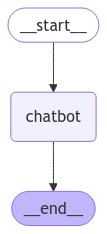

: 

In [37]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:

while True:
    user_input = input("User: ")
    print("User: "+ user_input)
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [ ]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatAnthropic(model="claude-3-haiku-20240307")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile()


### Enhancing Chatbot with s

part-1

In [1]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [2]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [3]:
graph_builder.add_edge(START, "chatbot")

In [4]:

graph_builder.add_edge("chatbot", END)

In [5]:
graph = graph_builder.compile()

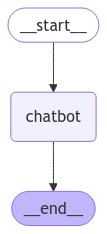

In [6]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [7]:
while True:
    user_input = input("User: ")
    print("User: "+ user_input)
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

User: quit
Goodbye!


In [8]:
%%capture --no-stderr
%pip install -U tavily-python
%pip install -U langchain_community

In [10]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': "In LangGraph, each node represents an LLM agent, and the edges are the communication channels between these agents. This structure allows for clear and manageable workflows, where each agent performs specific tasks and passes information to other agents as needed. State management. One of LangGraph's standout features is its automatic state ..."},
 {'url': 'https://medium.com/@kbdhunga/beginners-guide-to-langgraph-understanding-state-nodes-and-edges-part-1-897e6114fa48',
  'content': 'Each node in a LangGraph graph has the ability to access, read, and write to the state. When a node modifies the state, it effectively broadcasts this information to all other nodes within the graph .'}]

In [18]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


In [19]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

AttributeError: 'function' object has no attribute 'name'

In [20]:
from typing import Literal


def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "__end__" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", "__end__": "__end__"},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

ValueError: Found edge starting at unknown node 'tools'

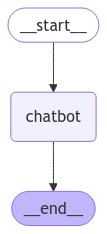

In [21]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [22]:

from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

Goodbye!


In [23]:

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [24]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-haiku-20240307")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

ModuleNotFoundError: No module named 'langchain_anthropic'

In [25]:
graph = graph_builder.compile(checkpointer=memory)

ValueError: Found edge starting at unknown node 'tools'

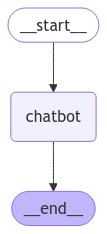

In [26]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [27]:

config = {"configurable": {"thread_id": "1"}}

In [28]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hello, Will! It's nice to meet you. My name is Gemini. How can I help you today?


In [29]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I do not have the ability to remember your name as I am just a chatbot assistant and do not have a memory.


In [30]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I am Gemini, a multimodal AI language model developed by Google. I do not have a name, as I am not a person.


In [31]:
snapshot = graph.get_state(config)
snapshot

ValueError: No checkpointer set

In [34]:
snapshot.next  # (since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)

NameError: name 'snapshot' is not defined

In [ ]:
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, MessagesState, START, END

model = ChatOpenAI(model="gpt-4o-mini")


def call_model(state: MessagesState):
    response = model.invoke(state['messages'])
    return {"messages": response}

workflow = StateGraph(MessagesState)
workflow.add_node(call_model)
workflow.add_edge(START, "call_model")
workflow.add_edge("call_model", END)
app = workflow.compile()

inputs = [{"role": "user", "content": "hi!"}]
async for event in app.astream_events({"messages": inputs}, version="v1"):
    kind = event["event"]
    print(f"{kind}: {event['name']}")